In [10]:
import sys
import copy
import importlib
import matplotlib.pyplot as plt

In [2]:
sys.path.append('./')
import data_struct

In [3]:
importlib.reload(data_struct)

<module 'data_struct' from '/Users/zhushuli/Projects.localized/PyCharm/IPIN22_Track6/data_struct.py'>

## 真值轨迹

In [6]:
posi_units = []
with open('./trials2023/POSI_testingData.txt', 'r') as fd:
    for line in fd:
        unit = data_struct.posiUnit(line.strip())
        posi_units.append(unit)
print(len(posi_units))

5494


In [7]:
with open('./trials2023/POSI_trajectory.csv', 'w') as fd:
    fd.write('lon,lat\n')
    for u in posi_units:
        fd.write(u.loc_gcj02_str + '\n')

## GNSS轨迹

In [8]:
gnss_units = []
with open('./trials2023/mate20MeaDataRecorder_testingData.txt', 'r') as fd:
    for line in fd:
        if line.startswith('GNSS'):
            unit = data_struct.gnssUnit(line.strip())
            gnss_units.append(unit)
print(len(gnss_units))

2968


In [9]:
with open('./trials2023/GNSS_trajectory.csv', 'w') as fd:
    fd.write('lon,lat\n')
    for u in gnss_units:
        fd.write(u.loc_gcj02_str + '\n')

## GNSS速度

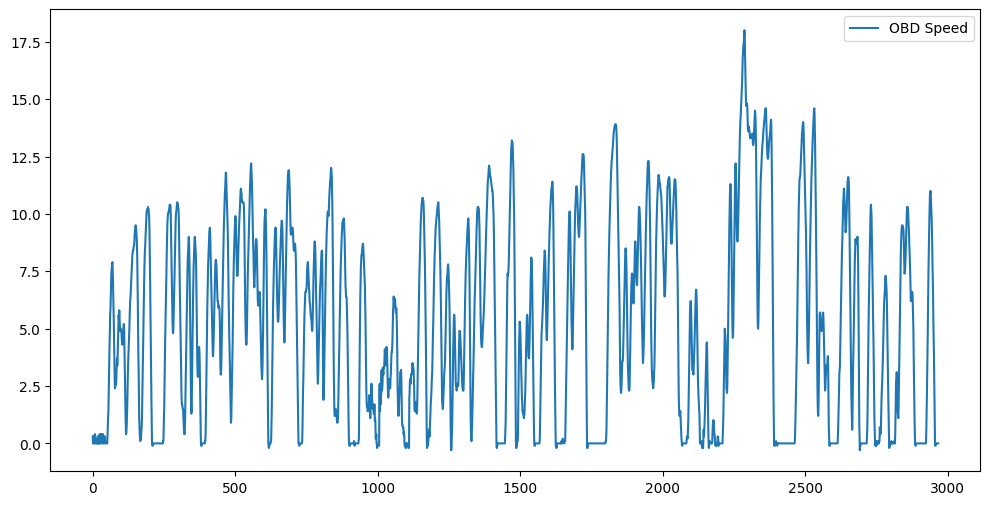

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot([u.speed for u in gnss_units], label='GNSS Speed')

ax.legend()
plt.show()

## OBD速度

In [10]:
obd_units = []
with open('./trials2023/mate20MeaDataRecorder_testingData.txt', 'r') as fd:
    for line in fd:
        if line.startswith('OBD'):
            unit = data_struct.obdUnit(line.strip())
            obd_units.append(unit)
print(len(obd_units))

109737


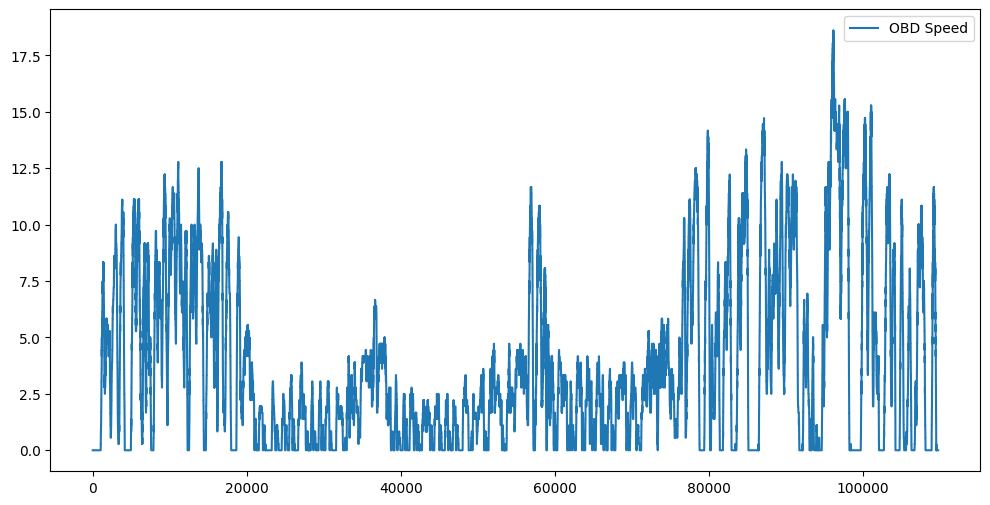

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot([u.vehicle_speed for u in obd_units], label='OBD Speed')

ax.legend()
plt.show()

## 加速度计

In [5]:
acce_units = []

# with open('./trials/IPIN2022_T7_TestingTrial01.txt', 'r') as fd:
#     for line in fd:
#         if line.startswith('ACCE'):
#             unit = data_struct.acceUnit(line.strip())
#             acce_units.append(unit)    

with open('./trials2023/mate20MeaDataRecorder_testingData.txt', 'r') as fd:
    for line in fd:
        if line.startswith('ACCE'):
            unit = data_struct.acceUnit(line.strip())
            acce_units.append(unit)        
            
print(len(acce_units))

1373497


In [23]:
def mean_filter(acce_units, alpha=0.5):
    filtered_acce_units = []
    for u in acce_units:
        if len(filtered_acce_units) == 0:
            filtered_acce_units.append(u)
        else:
            unit = copy.deepcopy(u)
            unit.acc_x = filtered_acce_units[-1].acc_x * alpha + u.acc_x * (1 - alpha)
            unit.acc_y = filtered_acce_units[-1].acc_y * alpha + u.acc_y * (1 - alpha)
            unit.acc_z = filtered_acce_units[-1].acc_z * alpha + u.acc_z * (1 - alpha)
            filtered_acce_units.append(unit)
    return filtered_acce_units


filtered_acce_units = mean_filter(acce_units, alpha=0.8)

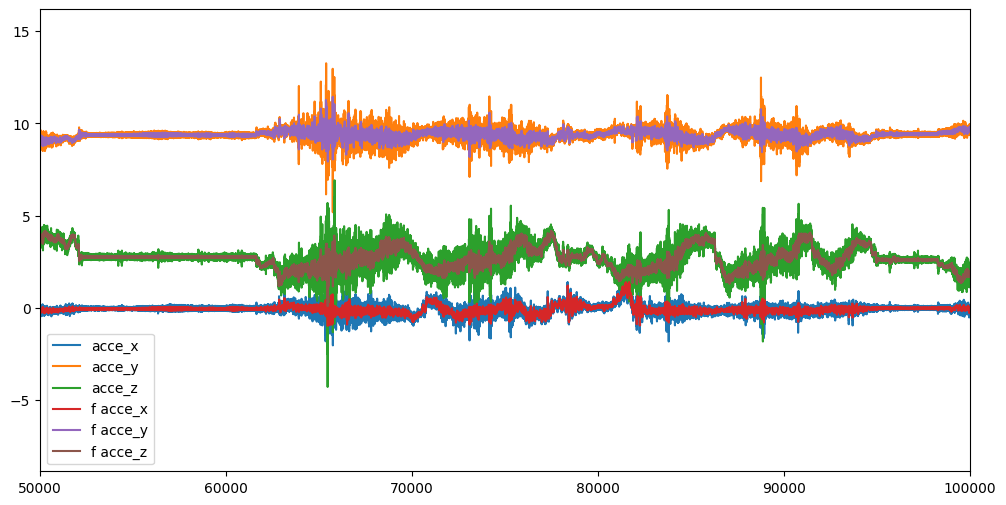

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot([u.sen_x for u in acce_units], label='acce_x')
ax.plot([u.sen_y for u in acce_units], label='acce_y')
ax.plot([u.sen_z for u in acce_units], label='acce_z')
ax.plot([u.sen_x for u in filtered_acce_units], label='f acce_x')
ax.plot([u.sen_y for u in filtered_acce_units], label='f acce_y')
ax.plot([u.sen_z for u in filtered_acce_units], label='f acce_z')

# ax.set_ylim(-15, 15)
ax.set_xlim(50000, 100000)

ax.legend()
plt.show()
plt.close()

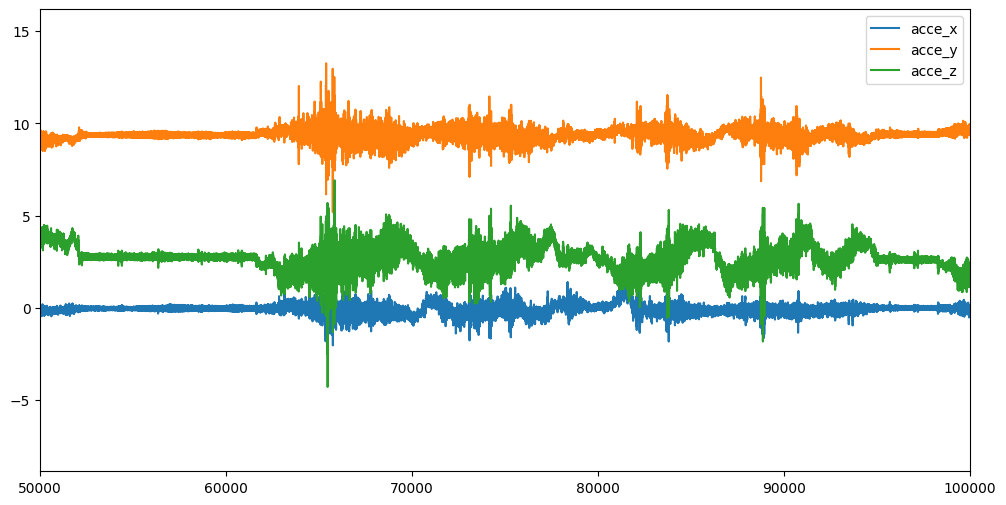

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot([u.sen_x for u in acce_units], label='acce_x')
ax.plot([u.sen_y for u in acce_units], label='acce_y')
ax.plot([u.sen_z for u in acce_units], label='acce_z')

ax.set_xlim(50000, 100000)

ax.legend()
plt.show()
plt.close()